Poker Hand Induction Dataset
<br><br>https://www.kaggle.com/c/poker-rule-induction/data
<br><br>Fastai v2 best result: 99,48% (I suspect it could improve, cause the validation error kept slowly decreasing, but I did not have more time to keep training)
<br><br>TabNet best result: 99,10% (Also suspect it could get better)
<br><br>Most pain for fastai was setting hyperparameters (number of layers, number of neurons in each one, and dropouts). For TabNet, the same thing (n_d, n_a, n_steps)
<br><br>Crucial: treat ranks also as categories, not only as continuous
<br><br>
Based on the work of:
<br><br>https://github.com/muellerzr/fastai2-Tabular-Baselines
<br>and
<br>https://github.com/mgrankin/fast_tabnet

In [1]:
from fastai2.basics import *
from fastai2.tabular.all import *
from fast_tabnet.core import *

In [2]:
df = pd.read_csv('/media/hdd3tb/data/kaggle_pokerhand/train.csv')

In [3]:
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,4,9,2,1,2,2,4,7,2,8,0
1,1,4,3,6,1,12,3,11,2,7,0
2,1,11,4,1,3,7,4,11,2,1,2
3,2,9,2,4,3,6,1,9,4,9,3
4,1,8,2,4,2,11,2,2,2,1,0


In [4]:
for i in range(1,6):
    df['cC'+str(i)]=df['C'+str(i)]

In [5]:
cat_vars = ['S1', 'S2', 'S3', 'S4', 'S5','cC1', 'cC2', 'cC3', 'cC4', 'cC5']
cont_vars = ['C1', 'C2', 'C3', 'C4', 'C5']
dep_var = ['hand']

In [6]:
procs = [Categorify, Normalize]
splits = RandomSplitter()(range_of(df))

In [7]:
splits

((#20008) [13754,14876,18829,10293,4025,4400,20936,23973,1598,7154...],
 (#5002) [22522,2427,4864,5268,5443,22481,17717,1125,21068,22104...])

In [8]:
to = TabularPandas(df, procs, cat_names=cat_vars, cont_names=cont_vars, y_names=dep_var, splits=splits)

In [9]:
to

       S1        C1  S2        C2  S3        C3  S4        C4  S5        C5  \
13754   2 -1.599920   4  1.324929   2  0.799986   1  0.282297   2 -0.527964   
14876   1 -0.264228   2 -1.332473   1  1.066844   4  0.015382   1 -0.795510   
18829   3  1.605741   1  1.324929   1 -0.267445   3 -0.518449   4  1.612401   
10293   2  0.804326   3 -0.800992   4  0.799986   1  0.549212   1 -0.795510   
4025    2 -1.332781   3  0.261968   1  1.333701   1 -0.251534   1  0.274673   
...    ..       ...  ..       ...  ..       ...  ..       ...  ..       ...   
6507    3  1.605741   1 -0.269512   2 -0.000587   1  0.549212   4  1.344855   
15187   4  0.270049   1  0.527708   2  0.799986   3 -0.785364   3 -0.527964   
16585   1  1.071464   4  0.793448   1  1.600559   1  0.282297   2  1.612401   
730     2 -1.332781   1 -1.332473   3  0.266271   2  0.282297   2  1.612401   
343     1  1.605741   1 -0.535252   3 -1.068017   4  1.083043   1  0.274673   

       hand  cC1  cC2  cC3  cC4  cC5  
13754     0 

In [10]:
dls = to.dataloaders(bs=512)

In [11]:
dls.show_batch()

,S1,S2,S3,S4,S5,cC1,cC2,cC3,cC4,cC5,C1,C2,C3,C4,C5,hand
0,3,3,4,4,4,13,2,1,8,11,13.0,2.0,1.0,8.0,11.0,0.0
1,2,4,3,1,4,2,5,5,12,4,2.0,5.0,5.0,12.0,4.0,1.0
2,4,2,4,3,1,1,6,3,3,2,1.0,6.0,3.0,3.0,2.0,1.0
3,4,2,2,2,3,3,1,9,2,6,3.0,1.0,9.0,2.0,6.0,0.0
4,2,1,2,4,4,7,6,13,4,1,7.0,6.0,13.0,4.0,1.0,0.0
5,1,3,1,3,4,6,5,4,9,9,6.0,5.0,4.0,9.0,9.0,1.0
6,1,4,3,4,4,6,6,4,3,12,6.0,6.0,4.0,3.0,12.0,1.0
7,3,3,4,1,4,3,5,12,7,4,3.0,5.0,12.0,7.0,4.0,0.0
8,4,1,4,2,3,12,11,1,8,4,12.0,11.0,1.0,8.0,4.0,0.0
9,4,3,4,4,3,9,2,3,13,12,9.0,2.0,3.0,13.0,12.0,0.0


In [12]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [13]:
learn = tabular_learner(dls, layers=[100, 50, 50], ps=[0.01, 0.01, 0.02], metrics=accuracy, opt_func=ranger, loss_func=CrossEntropyLossFlat(),n_out=10)

In [14]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(5, 4)
    (2): Embedding(5, 4)
    (3): Embedding(5, 4)
    (4): Embedding(5, 4)
    (5): Embedding(14, 7)
    (6): Embedding(14, 7)
    (7): Embedding(14, 7)
    (8): Embedding(14, 7)
    (9): Embedding(14, 7)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.01, inplace=False)
      (2): Linear(in_features=60, out_features=100, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.01, inplace=False)
      (2): Linear(in_features=100, out_features=50, bias=False)
      (3): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Batch

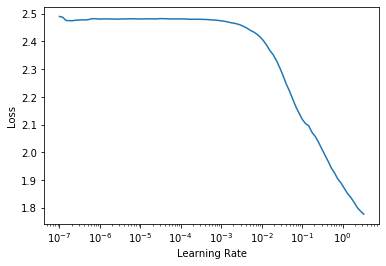

In [15]:
learn.lr_find()

In [16]:
learn.fit_flat_cos(10, 5e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.095707,1.009544,0.498601,00:00
1,1.025669,0.994494,0.498601,00:00
2,1.005917,0.984469,0.477009,00:00
3,0.986155,0.933339,0.580368,00:00
4,0.950008,1.001862,0.560176,00:00
5,0.927144,0.869359,0.628549,00:00
6,0.908951,0.942737,0.574570,00:00
7,0.873759,0.799082,0.672531,00:00
8,0.822703,0.748515,0.702719,00:00
9,0.766279,0.724835,0.715314,00:00


In [17]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.703107,0.708222,0.722911,00:00
1,0.701577,0.690147,0.728709,00:00
2,0.696967,0.690677,0.734506,00:00
3,0.687542,0.684044,0.737505,00:00
4,0.678709,0.720408,0.715514,00:00
5,0.673764,0.667923,0.740504,00:00
6,0.667026,0.681846,0.727509,00:00
7,0.659551,0.658902,0.750900,00:00
8,0.643979,0.653644,0.738105,00:00
9,0.623888,0.640697,0.758497,00:00


In [18]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.618588,0.639769,0.756297,00:00
1,0.606054,0.607538,0.769492,00:00
2,0.595492,0.605577,0.770492,00:00
3,0.582300,0.589636,0.777089,00:00
4,0.575185,0.586807,0.779688,00:00
5,0.565130,0.578564,0.783886,00:00
6,0.555115,0.571112,0.789284,00:00
7,0.544229,0.570191,0.791483,00:00
8,0.529744,0.553652,0.789684,00:00
9,0.506441,0.546148,0.799080,00:00


In [19]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.509265,0.545718,0.797081,00:00
1,0.506392,0.517670,0.817873,00:00
2,0.491518,0.517007,0.815674,00:00
3,0.475927,0.502419,0.827069,00:00
4,0.463403,0.503683,0.818673,00:00
5,0.444941,0.444861,0.845862,00:00
6,0.426255,0.458886,0.828269,00:00
7,0.415736,0.427232,0.848261,00:00
8,0.394979,0.415868,0.851459,00:00
9,0.363732,0.403301,0.857457,00:00


In [20]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.391972,0.422348,0.844862,00:00
1,0.380425,0.400675,0.853059,00:00
2,0.370749,0.412579,0.850060,00:00
3,0.360501,0.384574,0.860256,00:00
4,0.360464,0.366626,0.859056,00:00
5,0.350837,0.356270,0.867453,00:00
6,0.336666,0.368816,0.871851,00:00
7,0.323268,0.338968,0.881447,00:00
8,0.312099,0.312927,0.894642,00:00
9,0.283256,0.309781,0.894242,00:00


In [21]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.301421,0.348823,0.887245,00:00
1,0.295474,0.302146,0.905238,00:00
2,0.292166,0.334475,0.898041,00:00
3,0.280480,0.276151,0.908237,00:00
4,0.267522,0.257014,0.917033,00:00
5,0.262320,0.244011,0.923830,00:00
6,0.250943,0.257360,0.920232,00:00
7,0.246989,0.275291,0.934026,00:00
8,0.227922,0.241692,0.939624,00:00
9,0.204062,0.203977,0.942223,00:00


In [22]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.235563,0.240402,0.926230,00:00
1,0.240048,0.227530,0.931627,00:00
2,0.229366,0.258527,0.924630,00:00
3,0.225691,0.254311,0.940024,00:00
4,0.217914,0.202627,0.939024,00:00
5,0.214946,0.190855,0.944222,00:00
6,0.207871,0.209944,0.939224,00:00
7,0.206582,0.169187,0.954218,00:00
8,0.188571,0.148100,0.956218,00:00
9,0.163546,0.137381,0.962015,00:00


In [23]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.175680,0.200015,0.941623,00:00
1,0.196481,0.154853,0.958217,00:00
2,0.189535,0.216122,0.940224,00:00
3,0.180269,0.137799,0.963015,00:00
4,0.177924,0.140351,0.961615,00:00
5,0.166251,0.121068,0.966813,00:00
6,0.162465,0.143284,0.958417,00:00
7,0.162413,0.116428,0.968613,00:00
8,0.146753,0.101567,0.974010,00:00
9,0.127524,0.097506,0.975810,00:00


In [24]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.152605,0.145620,0.959816,00:00
1,0.158407,0.106001,0.971811,00:00
2,0.154438,0.156988,0.953819,00:00
3,0.150067,0.105423,0.973411,00:00
4,0.145319,0.105648,0.973011,00:00
5,0.148475,0.119495,0.972411,00:00
6,0.144736,0.132330,0.963814,00:00
7,0.148158,0.102924,0.974210,00:00
8,0.137139,0.094916,0.976609,00:00
9,0.118442,0.086758,0.980208,00:00


In [25]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.144125,0.119487,0.969412,00:00
1,0.150059,0.104319,0.976210,00:00
2,0.140316,0.117334,0.968413,00:00
3,0.144792,0.099643,0.972611,00:00
4,0.136979,0.099706,0.973211,00:00
5,0.131114,0.086474,0.978009,00:00
6,0.130457,0.104779,0.975610,00:00
7,0.128900,0.085956,0.978209,00:00
8,0.118139,0.066000,0.982607,00:00
9,0.099075,0.063265,0.982807,00:00


In [26]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.119899,0.127951,0.968613,00:00
1,0.125727,0.087809,0.977009,00:00
2,0.129507,0.109850,0.972211,00:00
3,0.133063,0.080664,0.980008,00:00
4,0.136062,0.103782,0.977209,00:00
5,0.137890,0.092997,0.976010,00:00
6,0.131989,0.190375,0.967813,00:00
7,0.125583,0.076277,0.980808,00:00
8,0.112683,0.066245,0.982007,00:00
9,0.093429,0.061680,0.985206,00:00


In [27]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.115156,0.116736,0.966613,00:00
1,0.129052,0.087530,0.979208,00:00
2,0.123489,0.091186,0.977809,00:00
3,0.118562,0.086285,0.980808,00:00
4,0.117171,0.092424,0.977209,00:00
5,0.118782,0.078850,0.979008,00:00
6,0.115657,0.104765,0.977409,00:00
7,0.116090,0.075393,0.981607,00:00
8,0.103810,0.067511,0.984606,00:00
9,0.083364,0.058404,0.987605,00:00


In [28]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.101212,0.098045,0.975210,00:00
1,0.122601,0.076915,0.980608,00:00
2,0.119039,0.086788,0.983607,00:00
3,0.117568,0.080952,0.981407,00:00
4,0.113230,0.090494,0.976010,00:00
5,0.109680,2.403957,0.981607,00:00
6,0.109379,0.755856,0.974810,00:00
7,0.108504,0.073085,0.987205,00:00
8,0.100550,0.068834,0.988405,00:00
9,0.084356,0.066633,0.988205,00:00


In [29]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.093729,0.091257,0.979208,00:00
1,0.109620,0.075455,0.985406,00:00
2,0.106692,0.075470,0.983407,00:00
3,0.100409,0.061263,0.988405,00:00
4,0.104254,0.095642,0.979008,00:00
5,0.111705,0.074540,0.985006,00:00
6,0.106985,0.070112,0.985606,00:00
7,0.108665,0.066207,0.985406,00:00
8,0.098820,0.061200,0.988804,00:00
9,0.079737,0.055899,0.989604,00:00


In [30]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.088624,0.083921,0.981207,00:00
1,0.103977,0.072036,0.985806,00:00
2,0.106468,0.078709,0.982807,00:00
3,0.109575,0.060757,0.986605,00:00
4,0.101002,0.076699,0.978409,00:00
5,0.105173,0.064246,0.985806,00:00
6,0.103100,0.080365,0.981807,00:00
7,0.102438,0.047340,0.990804,00:00
8,0.089347,0.048453,0.991004,00:00
9,0.076298,0.044326,0.992203,00:00


In [31]:
learn.save('round2_9922')

# 99,22%

In [32]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.087229,0.072278,0.983607,00:00
1,0.088625,0.052496,0.989804,00:00
2,0.101286,0.073899,0.986006,00:00
3,0.097223,0.062939,0.987005,00:00
4,0.094356,0.061180,0.989004,00:00
5,0.096366,0.053586,0.990204,00:00
6,0.096964,0.081804,0.979608,00:00
7,0.096510,0.056761,0.990004,00:00
8,0.084992,0.049473,0.991803,00:00
9,0.070735,0.050248,0.991803,00:00


In [33]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.084043,0.101971,0.975610,00:00
1,0.095618,0.062820,0.984606,00:00
2,0.096767,0.056519,0.989004,00:00
3,0.093511,0.052478,0.990404,00:00
4,0.088617,0.058352,0.985406,00:00
5,0.089064,0.060835,0.987805,00:00
6,0.093548,0.056229,0.987805,00:00
7,0.090757,0.048711,0.989004,00:00
8,0.081158,0.042392,0.992603,00:00
9,0.065920,0.042576,0.993203,00:00


In [34]:
learn.save('round2_9932')

# 99,32%

In [35]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.087618,0.061250,0.987405,00:00
1,0.089557,0.047648,0.991004,00:00
2,0.091133,0.081432,0.980808,00:00
3,0.095366,0.057887,0.989604,00:00
4,0.097272,0.075162,0.986206,00:00
5,0.091331,0.055742,0.989804,00:00
6,0.088876,0.057546,0.988605,00:00
7,0.087106,0.056726,0.990604,00:00
8,0.080187,0.049102,0.992403,00:00
9,0.066803,0.047529,0.992803,00:00


In [36]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.068715,0.072990,0.987405,00:00
1,0.081853,0.055685,0.989804,00:00
2,0.088631,0.070447,0.989204,00:00
3,0.086703,0.060708,0.987805,00:00
4,0.085869,0.067374,0.987605,00:00
5,0.080146,0.054157,0.991204,00:00
6,0.088924,0.061917,0.991204,00:00
7,0.084274,0.051109,0.992003,00:00
8,0.078543,0.056882,0.991803,00:00
9,0.063481,0.053029,0.992803,00:00


In [37]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.067483,0.059359,0.991803,00:00
1,0.088870,0.067758,0.988605,00:00
2,0.089950,0.063303,0.989404,00:00
3,0.086029,0.048734,0.988804,00:00
4,0.081389,0.056452,0.990804,00:00
5,0.082451,0.058492,0.990604,00:00
6,0.087600,0.078073,0.985206,00:00
7,0.083642,0.059960,0.992603,00:00
8,0.072285,0.055030,0.992603,00:00
9,0.059930,0.052480,0.993003,00:00


In [38]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.073531,0.073263,0.988205,00:00
1,0.093654,0.065677,0.989004,00:00
2,0.088355,0.075832,0.986605,00:00
3,0.083262,0.059221,0.991204,00:00
4,0.078252,0.067108,0.989004,00:00
5,0.075939,0.055058,0.992803,00:00
6,0.076926,0.059846,0.991803,00:00
7,0.074188,0.059739,0.991803,00:00
8,0.063734,0.061627,0.991803,00:00
9,0.055137,0.052124,0.993403,00:00


In [39]:
learn.save('round2_9934')

# 99,35%

In [40]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.057933,0.078609,0.986006,00:00
1,0.073997,0.070080,0.991004,00:00
2,0.092029,0.163808,0.967413,00:00
3,0.093331,0.063814,0.990204,00:00
4,0.081867,0.062073,0.992003,00:00
5,0.077019,0.056401,0.991603,00:00
6,0.074790,0.073999,0.988205,00:00
7,0.075692,0.070749,0.990804,00:00
8,0.068894,0.057307,0.992603,00:00
9,0.055567,0.057976,0.991803,00:00


In [41]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.062460,0.073702,0.988804,00:00
1,0.079895,0.061796,0.990004,00:00
2,0.083881,0.078215,0.987805,00:00
3,0.079574,0.061458,0.992203,00:00
4,0.077857,0.070047,0.987005,00:00
5,0.073348,0.068124,0.989804,00:00
6,0.073373,0.072447,0.989204,00:00
7,0.072727,0.052745,0.991803,00:00
8,0.064619,0.061790,0.991803,00:00
9,0.050667,0.059886,0.992803,00:00


In [42]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.080831,0.068299,0.989204,00:00
1,0.081750,0.063672,0.990404,00:00
2,0.080336,0.067341,0.988005,00:00
3,0.071889,0.060541,0.990804,00:00
4,0.073559,0.066638,0.988804,00:00
5,0.070714,0.058792,0.992003,00:00
6,0.074203,0.059583,0.991603,00:00
7,0.072426,0.063349,0.992203,00:00
8,0.060755,0.060272,0.991803,00:00
9,0.049567,0.053728,0.992603,00:00


In [43]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.067576,0.075159,0.987005,00:00
1,0.074149,0.056974,0.991204,00:00
2,0.077929,0.065920,0.988605,00:00
3,0.076636,0.061774,0.990804,00:00
4,0.076331,0.068139,0.989004,00:00
5,0.071422,0.062096,0.991204,00:00
6,0.066661,0.064972,0.990404,00:00
7,0.070072,0.057775,0.992403,00:00
8,0.063298,0.057319,0.992603,00:00
9,0.049658,0.057378,0.992603,00:00


In [44]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.067677,0.071723,0.987205,00:00
1,0.073997,0.067979,0.989804,00:00
2,0.080711,0.070979,0.988605,00:00
3,0.078318,0.051427,0.992403,00:00
4,0.071630,0.069558,0.990804,00:00
5,0.066497,0.068181,0.991204,00:00
6,0.066186,0.079346,0.989004,00:00
7,0.075610,0.053620,0.992203,00:00
8,0.065009,0.054377,0.992803,00:00
9,0.049937,0.054770,0.993203,00:00


In [45]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.061414,0.069081,0.991204,00:00
1,0.068182,0.061162,0.991603,00:00
2,0.074194,0.120029,0.976210,00:00
3,0.074902,0.055440,0.993003,00:00
4,0.074435,0.064867,0.990604,00:00
5,0.069981,0.063232,0.993003,00:00
6,0.069670,0.080003,0.986405,00:00
7,0.067576,0.063999,0.991403,00:00
8,0.060592,0.059369,0.992803,00:00
9,0.047752,0.058403,0.992603,00:00


In [46]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.075261,0.088554,0.984806,00:00
1,0.094929,0.069051,0.989404,00:00
2,0.082187,0.081633,0.989804,00:00
3,0.071493,0.073185,0.991603,00:00
4,0.067319,0.074392,0.989004,00:00
5,0.066642,0.068139,0.990204,00:00
6,0.065006,0.084936,0.987605,00:00
7,0.064935,0.065483,0.991603,00:00
8,0.057868,0.064909,0.991603,00:00
9,0.047763,0.062357,0.992603,00:00


In [47]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.046456,0.076200,0.988605,00:00
1,0.068418,0.055394,0.993003,00:00
2,0.065291,0.073347,0.991204,00:00
3,0.066081,0.062800,0.991004,00:00
4,0.066334,0.081395,0.990604,00:00
5,0.076589,0.059823,0.990004,00:00
6,0.072038,0.080645,0.989604,00:00
7,0.066316,0.058367,0.990204,00:00
8,0.058149,0.060143,0.990804,00:00
9,0.042005,0.059069,0.991803,00:00


In [48]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047719,0.065003,0.990204,00:00
1,0.059281,0.057724,0.991803,00:00
2,0.065970,0.079985,0.988804,00:00
3,0.067570,0.065261,0.990804,00:00
4,0.065066,0.060761,0.991403,00:00
5,0.060183,0.063702,0.992803,00:00
6,0.060386,0.083404,0.987005,00:00
7,0.066779,0.057613,0.990804,00:00
8,0.059227,0.058225,0.992003,00:00
9,0.043766,0.058142,0.991803,00:00


In [49]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047966,0.075408,0.985206,00:00
1,0.063822,0.065969,0.989204,00:00
2,0.063832,0.080506,0.986405,00:00
3,0.070378,0.058167,0.990204,00:00
4,0.081989,0.082292,0.981807,00:00
5,0.078111,0.057766,0.990604,00:00
6,0.069108,0.065085,0.991403,00:00
7,0.059547,0.053135,0.992603,00:00
8,0.051855,0.052315,0.993403,00:00
9,0.042488,0.051370,0.994002,00:00


In [50]:
learn.save('round2_9940')

# 99,40%

In [51]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.054640,0.057163,0.990204,00:00
1,0.060339,0.054720,0.992203,00:00
2,0.063942,0.067123,0.988005,00:00
3,0.060911,0.054930,0.992603,00:00
4,0.060825,0.074387,0.991603,00:00
5,0.065602,0.059957,0.991004,00:00
6,0.066783,0.076305,0.983407,00:00
7,0.069945,0.057103,0.991603,00:00
8,0.059499,0.053924,0.990404,00:00
9,0.046542,0.052318,0.992603,00:00


In [52]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.049093,0.074629,0.988005,00:00
1,0.060225,0.064808,0.991204,00:00
2,0.057768,0.060086,0.992203,00:00
3,0.069072,0.063126,0.991004,00:00
4,0.070152,0.070487,0.989204,00:00
5,0.064806,0.056082,0.991004,00:00
6,0.063084,0.051668,0.992203,00:00
7,0.057348,0.056267,0.991603,00:00
8,0.047367,0.057775,0.991603,00:00
9,0.038906,0.053316,0.992203,00:00


In [53]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.043140,0.066328,0.989604,00:00
1,0.062118,0.057189,0.992003,00:00
2,0.061948,0.069929,0.988005,00:00
3,0.059203,0.065285,0.991004,00:00
4,0.060084,0.073198,0.986206,00:00
5,0.062434,0.065725,0.990404,00:00
6,0.062699,0.076801,0.984806,00:00
7,0.058710,0.057346,0.990204,00:00
8,0.049999,0.051471,0.992203,00:00
9,0.042686,0.049515,0.992203,00:00


In [54]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.066703,0.075820,0.987405,00:00
1,0.068500,0.054015,0.992203,00:00
2,0.062117,0.057211,0.990804,00:00
3,0.057057,0.047345,0.992403,00:00
4,0.058068,0.054858,0.989804,00:00
5,0.059379,0.073522,0.989804,00:00
6,0.059610,0.054942,0.989604,00:00
7,0.059120,0.051594,0.991803,00:00
8,0.050226,0.052750,0.990204,00:00
9,0.038847,0.053255,0.991403,00:00


In [55]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047530,0.075554,0.987405,00:00
1,0.058083,0.056842,0.989804,00:00
2,0.061001,0.066780,0.987005,00:00
3,0.075892,0.054433,0.989604,00:00
4,0.070578,0.056750,0.992203,00:00
5,0.062483,0.055830,0.990404,00:00
6,0.063257,0.064132,0.987205,00:00
7,0.057839,0.058255,0.992003,00:00
8,0.049829,0.059498,0.991004,00:00
9,0.038384,0.060180,0.990804,00:00


In [56]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.059065,0.083369,0.985206,00:00
1,0.066386,0.050140,0.988405,00:00
2,0.064033,0.080709,0.983007,00:00
3,0.064997,0.054315,0.990604,00:00
4,0.062780,0.049549,0.991403,00:00
5,0.060836,0.050669,0.991004,00:00
6,0.062682,0.084452,0.980408,00:00
7,0.067100,0.052481,0.989804,00:00
8,0.054788,0.049941,0.992203,00:00
9,0.040815,0.047902,0.991403,00:00


In [57]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047541,0.081831,0.984006,00:00
1,0.072399,0.061924,0.987405,00:00
2,0.075073,0.057268,0.989004,00:00
3,0.060949,0.057867,0.992003,00:00
4,0.054152,0.059757,0.990604,00:00
5,0.054672,0.054056,0.991803,00:00
6,0.059975,0.070934,0.989804,00:00
7,0.068831,0.058501,0.991204,00:00
8,0.055476,0.058492,0.989804,00:00
9,0.041290,0.056050,0.990604,00:00


In [58]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047966,0.074333,0.985806,00:00
1,0.060846,0.051057,0.990604,00:00
2,0.058252,0.073215,0.986206,00:00
3,0.060275,0.051270,0.992603,00:00
4,0.055710,0.057671,0.988605,00:00
5,0.053657,0.052458,0.990604,00:00
6,0.056799,0.099803,0.979208,00:00
7,0.067248,0.060554,0.990204,00:00
8,0.056324,0.057383,0.990604,00:00
9,0.042580,0.051040,0.991403,00:00


In [59]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.044714,0.062012,0.991004,00:00
1,0.055739,0.059330,0.989204,00:00
2,0.059752,0.059811,0.985806,00:00
3,0.063305,0.052956,0.991603,00:00
4,0.064264,0.071147,0.987405,00:00
5,0.065154,0.048666,0.990604,00:00
6,0.057984,0.055475,0.990004,00:00
7,0.053242,0.053451,0.992003,00:00
8,0.047197,0.044853,0.993003,00:00
9,0.037576,0.044255,0.993403,00:00


In [60]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.056298,0.064617,0.990204,00:00
1,0.061424,0.054406,0.991603,00:00
2,0.058644,0.057506,0.988405,00:00
3,0.063004,0.056542,0.991204,00:00
4,0.072377,0.071537,0.986805,00:00
5,0.068988,0.049922,0.991204,00:00
6,0.062187,0.056163,0.991004,00:00
7,0.057873,0.047799,0.992203,00:00
8,0.047755,0.049361,0.991603,00:00
9,0.038352,0.047188,0.992803,00:00


In [61]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.044185,0.072185,0.989404,00:00
1,0.061861,0.065750,0.989804,00:00
2,0.060469,0.062142,0.990204,00:00
3,0.062794,0.055597,0.990204,00:00
4,0.060033,0.055483,0.991204,00:00
5,0.061421,0.053464,0.992003,00:00
6,0.054060,0.054182,0.990404,00:00
7,0.055375,0.048653,0.990604,00:00
8,0.048073,0.055345,0.992203,00:00
9,0.038485,0.053173,0.992803,00:00


In [62]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.050483,0.072978,0.986206,00:00
1,0.062017,0.061654,0.990004,00:00
2,0.059755,0.069153,0.991004,00:00
3,0.060158,0.054698,0.992003,00:00
4,0.060917,0.071610,0.989804,00:00
5,0.058288,0.054669,0.990804,00:00
6,0.054741,0.058179,0.987605,00:00
7,0.053117,0.059264,0.989804,00:00
8,0.049405,0.052763,0.992003,00:00
9,0.038854,0.051859,0.992003,00:00


In [63]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.049577,0.084782,0.988804,00:00
1,0.059861,0.058254,0.990604,00:00
2,0.058732,0.057879,0.988005,00:00
3,0.053350,0.053353,0.990204,00:00
4,0.052626,0.080719,0.988405,00:00
5,0.060046,0.054559,0.991204,00:00
6,0.059685,0.071870,0.989204,00:00
7,0.059220,0.060354,0.990804,00:00
8,0.047958,0.052097,0.992603,00:00
9,0.035934,0.050495,0.992803,00:00


In [64]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047021,0.075540,0.988405,00:00
1,0.054882,0.064542,0.990004,00:00
2,0.059247,0.067830,0.988205,00:00
3,0.058117,0.052447,0.991204,00:00
4,0.059242,0.056994,0.988804,00:00
5,0.056670,0.057155,0.992003,00:00
6,0.063594,0.095905,0.978808,00:00
7,0.060633,0.055811,0.991004,00:00
8,0.052139,0.051050,0.990804,00:00
9,0.039781,0.050249,0.992203,00:00


In [65]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.048123,0.068352,0.989004,00:00
1,0.058670,0.057152,0.992603,00:00
2,0.064415,0.051866,0.990804,00:00
3,0.065871,0.053325,0.990404,00:00
4,0.064051,0.059910,0.988605,00:00
5,0.061217,0.047598,0.992403,00:00
6,0.057375,0.054603,0.989004,00:00
7,0.054091,0.055003,0.990804,00:00
8,0.048461,0.051230,0.993003,00:00
9,0.036456,0.048233,0.992803,00:00


In [66]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.051501,0.078305,0.985406,00:00
1,0.066418,0.050034,0.992603,00:00
2,0.066789,0.068066,0.985206,00:00
3,0.058972,0.049302,0.991204,00:00
4,0.057738,0.062882,0.988405,00:00
5,0.060694,0.055336,0.991004,00:00
6,0.056330,0.072097,0.987005,00:00
7,0.062369,0.069364,0.990204,00:00
8,0.054188,0.046028,0.993203,00:00
9,0.041021,0.046835,0.992203,00:00


In [67]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.044760,0.076743,0.989604,00:00
1,0.062020,0.051839,0.991803,00:00
2,0.061007,0.056109,0.988005,00:00
3,0.065051,0.059953,0.991004,00:00
4,0.067757,0.061134,0.988605,00:00
5,0.056652,0.047493,0.993003,00:00
6,0.049312,0.050096,0.990604,00:00
7,0.051873,0.044761,0.992603,00:00
8,0.044778,0.053656,0.992403,00:00
9,0.035525,0.046799,0.992203,00:00


In [68]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.042610,0.061721,0.989004,00:00
1,0.044663,0.048642,0.992603,00:00
2,0.055735,0.059510,0.985206,00:00
3,0.057830,0.052087,0.991803,00:00
4,0.060642,0.056027,0.988405,00:00
5,0.057923,0.048429,0.991603,00:00
6,0.053573,0.057949,0.987205,00:00
7,0.052617,0.052704,0.989404,00:00
8,0.049067,0.047091,0.992003,00:00
9,0.036738,0.046198,0.992203,00:00


In [69]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.059166,0.068697,0.988205,00:00
1,0.062097,0.057149,0.991204,00:00
2,0.059195,0.067253,0.991403,00:00
3,0.067077,0.048170,0.992203,00:00
4,0.059325,0.070686,0.988405,00:00
5,0.057938,0.055928,0.991004,00:00
6,0.058529,0.061590,0.988005,00:00
7,0.056238,0.071230,0.991204,00:00
8,0.047872,0.062604,0.990404,00:00
9,0.035338,0.061684,0.992603,00:00


In [70]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.034353,0.068930,0.990204,00:00
1,0.049018,0.059530,0.989804,00:00
2,0.051127,0.061153,0.987205,00:00
3,0.060214,0.059479,0.991204,00:00
4,0.054142,0.073656,0.987205,00:00
5,0.069839,0.050010,0.994402,00:00
6,0.060681,0.084632,0.991204,00:00
7,0.056051,0.053118,0.992203,00:00
8,0.044755,0.054507,0.992003,00:00
9,0.033954,0.052854,0.993003,00:00


In [71]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.040069,0.064153,0.989404,00:00
1,0.060721,0.054455,0.991204,00:00
2,0.056582,0.063222,0.989204,00:00
3,0.061035,0.060847,0.992003,00:00
4,0.063898,0.067721,0.991004,00:00
5,0.057281,0.049084,0.992603,00:00
6,0.053111,0.071497,0.986805,00:00
7,0.052727,0.059868,0.992603,00:00
8,0.049755,0.051391,0.992203,00:00
9,0.037618,0.049907,0.993203,00:00


In [72]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.036868,0.056637,0.989604,00:00
1,0.048931,0.066277,0.991004,00:00
2,0.060547,0.085254,0.983407,00:00
3,0.061069,0.058821,0.992403,00:00
4,0.053606,0.062193,0.989604,00:00
5,0.051468,0.059594,0.990604,00:00
6,0.049367,0.079676,0.990604,00:00
7,0.057152,0.051107,0.991204,00:00
8,0.050273,0.052045,0.993403,00:00
9,0.039679,0.049666,0.993603,00:00


In [73]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047529,0.064420,0.991603,00:00
1,0.054947,0.052270,0.991403,00:00
2,0.055465,0.064909,0.988605,00:00
3,0.064401,0.065853,0.991204,00:00
4,0.060384,0.074255,0.989004,00:00
5,0.053272,0.063150,0.990204,00:00
6,0.050822,0.071809,0.988405,00:00
7,0.051369,0.068873,0.992203,00:00
8,0.048869,0.061486,0.992803,00:00
9,0.036625,0.054942,0.992803,00:00


In [74]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.039925,0.058923,0.990604,00:00
1,0.048860,0.056089,0.993403,00:00
2,0.059975,0.108482,0.973211,00:00
3,0.065217,0.070804,0.990404,00:00
4,0.057083,0.066232,0.990004,00:00
5,0.051319,0.063550,0.991004,00:00
6,0.055316,0.054503,0.993203,00:00
7,0.059053,0.061352,0.991603,00:00
8,0.045276,0.060851,0.992803,00:00
9,0.033815,0.056994,0.992403,00:00


In [75]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.038194,0.072043,0.990404,00:00
1,0.054834,0.051451,0.992603,00:00
2,0.054734,0.070666,0.992403,00:00
3,0.059103,0.049126,0.991204,00:00
4,0.054700,0.056204,0.991004,00:00
5,0.065571,0.057245,0.993603,00:00
6,0.060120,0.058132,0.992603,00:00
7,0.056224,0.046166,0.991803,00:00
8,0.046311,0.054359,0.990804,00:00
9,0.033274,0.052891,0.992403,00:00


In [76]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.043874,0.065431,0.989004,00:00
1,0.051527,0.051777,0.991204,00:00
2,0.053172,0.062657,0.989804,00:00
3,0.054316,0.055470,0.992003,00:00
4,0.055717,0.067470,0.990404,00:00
5,0.055074,0.055725,0.991204,00:00
6,0.054670,0.066350,0.986206,00:00
7,0.052783,0.044856,0.993603,00:00
8,0.045787,0.044249,0.993403,00:00
9,0.033938,0.045695,0.994402,00:00


In [77]:
learn.save('round2_9944')

# 99,44%

In [78]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.038598,0.056682,0.991004,00:00
1,0.048812,0.052109,0.991403,00:00
2,0.063151,0.057884,0.988605,00:00
3,0.059753,0.053927,0.992203,00:00
4,0.053553,0.059624,0.990004,00:00
5,0.059904,0.044097,0.990604,00:00
6,0.066112,0.041579,0.990404,00:00
7,0.061308,0.077795,0.991803,00:00
8,0.051060,0.275716,0.992603,00:00
9,0.036705,0.050160,0.994402,00:00


In [79]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.052968,0.075825,0.990404,00:00
1,0.058135,0.058008,0.992203,00:00
2,0.055792,0.076314,0.988405,00:00
3,0.052265,0.069461,0.991204,00:00
4,0.052888,0.055553,0.989204,00:00
5,0.057611,0.048836,0.992403,00:00
6,0.051234,0.060607,0.991204,00:00
7,0.069673,0.065171,0.990004,00:00
8,0.059999,0.054181,0.990804,00:00
9,0.042923,0.052753,0.991803,00:00


In [80]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.037260,0.074988,0.991204,00:00
1,0.049982,0.046208,0.991204,00:00
2,0.056975,0.066666,0.988405,00:00
3,0.061471,0.049307,0.991004,00:00
4,0.056485,0.055431,0.990404,00:00
5,0.049859,0.059050,0.990804,00:00
6,0.051962,0.080492,0.982007,00:00
7,0.056649,0.051122,0.991803,00:00
8,0.048680,0.046580,0.992003,00:00
9,0.034779,0.421726,0.993203,00:00


In [81]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.046897,5.254215,0.986405,00:00
1,0.056106,0.054697,0.991204,00:00
2,0.054449,0.053640,0.991603,00:00
3,0.058044,0.054723,0.991803,00:00
4,0.052785,0.066794,0.989204,00:00
5,0.054352,0.047517,0.991803,00:00
6,0.056897,0.059768,0.988804,00:00
7,0.052040,0.054113,0.990804,00:00
8,0.047072,0.051658,0.992003,00:00
9,0.035567,0.045130,0.993203,00:00


In [82]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.034011,0.050196,0.991803,00:00
1,0.046266,0.047516,0.992203,00:00
2,0.049289,0.061492,0.988804,00:00
3,0.056006,0.059911,0.992403,00:00
4,0.054182,0.068740,0.988205,00:00
5,0.056514,0.051433,0.992203,00:00
6,0.066035,0.077430,0.990804,00:00
7,0.061120,0.053114,0.991803,00:00
8,0.048839,0.054313,0.992403,00:00
9,0.035074,0.051726,0.993802,00:00


In [83]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.042028,0.061504,0.990404,00:00
1,0.054080,0.047246,0.992203,00:00
2,0.053600,0.054271,0.992003,00:00
3,0.056977,0.051646,0.990604,00:00
4,0.053765,0.058619,0.989604,00:00
5,0.057495,0.043391,0.991403,00:00
6,0.057644,0.077746,0.985406,00:00
7,0.055732,0.060578,0.991403,00:00
8,0.047738,0.050394,0.993203,00:00
9,0.035783,0.047776,0.992803,00:00


In [84]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.039575,0.049457,0.990604,00:00
1,0.050577,0.050183,0.991603,00:00
2,0.067402,0.061531,0.990804,00:00
3,0.062167,0.044103,0.991403,00:00
4,0.059612,0.060959,0.989804,00:00
5,0.052091,0.054050,0.992203,00:00
6,0.049427,0.062105,0.990804,00:00
7,0.051782,0.067830,0.993203,00:00
8,0.044262,0.059443,0.993802,00:00
9,0.034680,0.062602,0.993603,00:00


In [85]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.058383,0.069536,0.990004,00:00
1,0.061809,0.058492,0.992003,00:00
2,0.054805,0.061452,0.990804,00:00
3,0.053846,0.066376,0.989804,00:00
4,0.048504,0.059017,0.993802,00:00
5,0.050237,0.047901,0.991603,00:00
6,0.051246,0.053513,0.992803,00:00
7,0.051097,0.051894,0.991803,00:00
8,0.040665,0.054511,0.993603,00:00
9,0.031031,0.052553,0.993403,00:00


In [86]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.040573,0.060445,0.990604,00:00
1,0.054334,0.054097,0.992003,00:00
2,0.053846,0.064983,0.989204,00:00
3,0.053892,0.051961,0.991403,00:00
4,0.048827,0.058422,0.988605,00:00
5,0.051473,0.066265,0.991603,00:00
6,0.051186,0.053730,0.991803,00:00
7,0.056550,0.051531,0.991803,00:00
8,0.048980,0.042643,0.993802,00:00
9,0.036569,0.042392,0.993403,00:00


In [87]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.053095,0.044224,0.992003,00:00
1,0.050099,0.039457,0.993403,00:00
2,0.051189,0.057929,0.990004,00:00
3,0.053395,0.047253,0.992803,00:00
4,0.054735,0.061300,0.988804,00:00
5,0.051146,0.058682,0.991803,00:00
6,0.050916,0.086895,0.988605,00:00
7,0.055993,0.048024,0.993603,00:00
8,0.049242,0.047496,0.992603,00:00
9,0.034334,0.046164,0.992803,00:00


In [88]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.035897,0.053668,0.991603,00:00
1,0.058964,0.063240,0.991004,00:00
2,0.065940,0.074117,0.988005,00:00
3,0.060445,0.056025,0.992203,00:00
4,0.057162,0.076374,0.983806,00:00
5,0.054038,0.066836,0.991204,00:00
6,0.050605,0.068615,0.992203,00:00
7,0.048597,0.063509,0.992803,00:00
8,0.042025,0.060543,0.993403,00:00
9,0.036274,0.063962,0.993203,00:00


In [89]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.049409,0.059321,0.992403,00:00
1,0.049708,0.060888,0.991204,00:00
2,0.054509,0.067471,0.987405,00:00
3,0.057290,0.068633,0.990204,00:00
4,0.052214,0.068783,0.990804,00:00
5,0.050518,0.046821,0.991803,00:00
6,0.047497,0.061355,0.990004,00:00
7,0.047273,0.065997,0.991204,00:00
8,0.044138,0.060979,0.990004,00:00
9,0.032600,0.050028,0.992803,00:00


In [90]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.053186,0.062156,0.990004,00:00
1,0.050979,0.056870,0.990204,00:00
2,0.050665,0.057128,0.990204,00:00
3,0.055028,0.057133,0.988804,00:00
4,0.060130,0.063187,0.984606,00:00
5,0.056118,0.049243,0.990804,00:00
6,0.053060,0.054285,0.990204,00:00
7,0.054259,0.049649,0.991803,00:00
8,0.048021,0.042192,0.991803,00:00
9,0.034682,0.038538,0.994402,00:00


In [91]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.057273,0.064435,0.986206,00:00
1,0.058170,0.047242,0.991803,00:00
2,0.057968,0.062198,0.989604,00:00
3,0.056415,0.042794,0.992803,00:00
4,0.055012,0.067468,0.989604,00:00
5,0.055867,0.045250,0.992603,00:00
6,0.052282,0.048353,0.992803,00:00
7,0.046486,0.046976,0.993203,00:00
8,0.041872,0.041193,0.993603,00:00
9,0.030622,0.039352,0.994002,00:00


In [92]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.040822,0.056659,0.990604,00:00
1,0.061074,0.046909,0.991204,00:00
2,0.058756,0.044744,0.989404,00:00
3,0.051497,0.060860,0.992203,00:00
4,0.052306,0.054375,0.989804,00:00
5,0.052466,0.047083,0.990804,00:00
6,0.053218,0.047778,0.993003,00:00
7,0.054501,0.054453,0.992603,00:00
8,0.046148,0.051317,0.993403,00:00
9,0.035463,0.050073,0.993802,00:00


In [93]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.046297,0.055601,0.991803,00:00
1,0.049619,0.046434,0.992603,00:00
2,0.055444,0.059402,0.988605,00:00
3,0.053652,0.049800,0.991403,00:00
4,0.050246,0.054972,0.988804,00:00
5,0.050419,0.040458,0.992003,00:00
6,0.047055,0.056814,0.988005,00:00
7,0.044894,0.051772,0.991204,00:00
8,0.040015,0.049052,0.992603,00:00
9,0.030795,0.048353,0.992603,00:00


In [94]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.048264,0.068468,0.990204,00:00
1,0.057829,0.052540,0.991403,00:00
2,0.064309,0.059826,0.989604,00:00
3,0.056996,0.047022,0.991803,00:00
4,0.053282,0.052614,0.987805,00:00
5,0.051519,0.042572,0.992003,00:00
6,0.055350,0.062510,0.989004,00:00
7,0.050614,0.052037,0.991004,00:00
8,0.043343,0.049361,0.992403,00:00
9,0.030581,0.049090,0.992403,00:00


In [95]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.034197,0.084275,0.984406,00:00
1,0.055296,0.053124,0.991204,00:00
2,0.049565,0.067021,0.987005,00:00
3,0.050642,0.047525,0.992603,00:00
4,0.052722,0.052645,0.988804,00:00
5,0.053309,0.047306,0.990604,00:00
6,0.060581,0.082531,0.978808,00:00
7,0.056964,0.045545,0.991603,00:00
8,0.047755,0.045766,0.993203,00:00
9,0.036010,0.044659,0.992403,00:00


In [96]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.032938,0.054853,0.991403,00:00
1,0.053685,0.068903,0.990804,00:00
2,0.057077,0.070111,0.991403,00:00
3,0.047636,0.058588,0.993003,00:00
4,0.049598,0.074241,0.987605,00:00
5,0.052581,0.048357,0.991603,00:00
6,0.046159,0.051050,0.992403,00:00
7,0.048053,0.061818,0.991603,00:00
8,0.046482,0.054618,0.991603,00:00
9,0.035180,0.051611,0.992403,00:00


In [97]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.034248,0.056516,0.991403,00:00
1,0.046858,0.077986,0.991204,00:00
2,0.056251,0.063434,0.985006,00:00
3,0.053869,0.054320,0.991803,00:00
4,0.058619,0.061702,0.987405,00:00
5,0.058116,0.048715,0.991004,00:00
6,0.051055,0.061464,0.989804,00:00
7,0.054013,0.048119,0.992203,00:00
8,0.044123,0.051350,0.992403,00:00
9,0.034127,0.044304,0.992803,00:00


In [98]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.035312,0.072736,0.988804,00:00
1,0.056121,0.059632,0.990804,00:00
2,0.053862,0.063499,0.991403,00:00
3,0.052703,0.048855,0.992203,00:00
4,0.046831,0.046122,0.991603,00:00
5,0.044385,0.052166,0.992603,00:00
6,0.055361,0.061084,0.989804,00:00
7,0.054299,0.056012,0.992403,00:00
8,0.045399,0.047899,0.993003,00:00
9,0.033923,0.047089,0.992803,00:00


In [99]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.038688,0.093389,0.979008,00:00
1,0.048895,0.058696,0.991603,00:00
2,0.052956,0.074125,0.990404,00:00
3,0.056691,0.074269,0.991603,00:00
4,0.058246,0.052131,0.991204,00:00
5,0.052648,0.060775,0.990604,00:00
6,0.055417,0.061539,0.990404,00:00
7,0.051687,0.053449,0.992203,00:00
8,0.042805,0.046889,0.992603,00:00
9,0.031878,0.047613,0.993403,00:00


In [100]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.033456,0.125485,0.991004,00:00
1,0.057305,0.076574,0.992203,00:00
2,0.056468,0.078553,0.989404,00:00
3,0.060252,0.087703,0.991204,00:00
4,0.055371,0.062818,0.991803,00:00
5,0.056007,0.049929,0.993603,00:00
6,0.054304,0.051201,0.991803,00:00
7,0.049839,0.047918,0.991004,00:00
8,0.044949,0.043040,0.993603,00:00
9,0.034359,0.041618,0.993003,00:00


In [101]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.039041,0.055693,0.992003,00:00
1,0.052693,0.057138,0.992003,00:00
2,0.058932,0.073974,0.988005,00:00
3,0.063159,0.077036,0.991403,00:00
4,0.054534,0.064706,0.991204,00:00
5,0.050281,0.062853,0.992603,00:00
6,0.050975,0.058125,0.990004,00:00
7,0.048775,0.059525,0.992203,00:00
8,0.040287,0.068598,0.993802,00:00
9,0.028883,0.065839,0.994202,00:00


In [102]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.040761,0.064707,0.990804,00:00
1,0.047765,0.057786,0.993003,00:00
2,0.057780,0.078820,0.989004,00:00
3,0.052691,0.049163,0.992403,00:00
4,0.051390,0.082672,0.979808,00:00
5,0.054414,0.049427,0.992603,00:00
6,0.051171,0.052333,0.992203,00:00
7,0.049710,0.047536,0.993403,00:00
8,0.044778,0.053007,0.993603,00:00
9,0.033024,0.044908,0.993203,00:00


In [103]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.045985,0.067276,0.992003,00:00
1,0.065682,0.057104,0.990604,00:00
2,0.058911,0.067586,0.986405,00:00
3,0.059873,0.044297,0.992403,00:00
4,0.051557,0.054474,0.990804,00:00
5,0.054504,0.076893,0.991204,00:00
6,0.056349,0.049333,0.992803,00:00
7,0.055773,0.043055,0.992803,00:00
8,0.045006,0.044006,0.993403,00:00
9,0.031854,0.043985,0.994002,00:00


In [104]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.050938,0.056933,0.991004,00:00
1,0.056389,0.054877,0.992003,00:00
2,0.063194,0.061120,0.991004,00:00
3,0.057593,0.045598,0.991803,00:00
4,0.050707,0.054311,0.990604,00:00
5,0.050721,0.044107,0.994002,00:00
6,0.046470,0.052939,0.992403,00:00
7,0.048276,0.046963,0.993203,00:00
8,0.042669,0.044754,0.993603,00:00
9,0.032158,0.041602,0.994402,00:00


In [105]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.065554,0.090095,0.981207,00:00
1,0.073677,0.056737,0.992003,00:00
2,0.064659,0.081474,0.989604,00:00
3,0.064908,0.068652,0.992203,00:00
4,0.058736,0.054254,0.989204,00:00
5,0.048301,0.052408,0.991803,00:00
6,0.043010,0.065962,0.987205,00:00
7,0.047095,0.058127,0.992003,00:00
8,0.043587,0.059349,0.992803,00:00
9,0.032820,0.057020,0.993802,00:00


In [106]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.045991,0.059650,0.991603,00:00
1,0.070239,0.049422,0.991204,00:00
2,0.062918,0.054656,0.989204,00:00
3,0.056035,0.045560,0.992803,00:00
4,0.052945,0.051312,0.989804,00:00
5,0.048619,0.045924,0.991803,00:00
6,0.044997,0.053941,0.991204,00:00
7,0.050001,0.040400,0.991403,00:00
8,0.050495,0.041653,0.992003,00:00
9,0.036229,0.035747,0.993003,00:00


In [107]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.041833,0.054906,0.988605,00:00
1,0.058794,0.047981,0.991603,00:00
2,0.068388,0.072359,0.986805,00:00
3,0.064340,0.038692,0.993203,00:00
4,0.059338,0.038570,0.993203,00:00
5,0.055026,0.046876,0.991204,00:00
6,0.051306,0.056817,0.991004,00:00
7,0.051451,0.050100,0.991603,00:00
8,0.042237,0.043862,0.993802,00:00
9,0.035310,0.041120,0.994402,00:00


In [108]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.039294,0.066266,0.983207,00:00
1,0.051890,0.042212,0.992003,00:00
2,0.064167,0.109125,0.974810,00:00
3,0.061437,0.047519,0.991204,00:00
4,0.047908,0.053712,0.991403,00:00
5,0.062575,0.053246,0.991204,00:00
6,0.060704,0.061042,0.990604,00:00
7,0.050649,0.055460,0.993403,00:00
8,0.041896,0.052483,0.992803,00:00
9,0.032187,0.051883,0.993203,00:00


In [109]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.034177,0.059205,0.991803,00:00
1,0.042803,0.046011,0.992603,00:00
2,0.050588,0.086186,0.978609,00:00
3,0.062256,0.052172,0.990804,00:00
4,0.061439,0.052578,0.992203,00:00
5,0.055512,0.047157,0.992803,00:00
6,0.049721,0.059943,0.989804,00:00
7,0.053556,0.044309,0.992403,00:00
8,0.045028,0.052196,0.993003,00:00
9,0.034232,0.047675,0.993003,00:00


In [110]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.043851,0.061535,0.991803,00:00
1,0.055346,0.051615,0.991403,00:00
2,0.073599,0.102423,0.975410,00:00
3,0.070145,0.050313,0.992603,00:00
4,0.056311,0.065321,0.986805,00:00
5,0.047806,0.060358,0.991803,00:00
6,0.042752,0.051903,0.992603,00:00
7,0.048989,0.043554,0.992003,00:00
8,0.040789,0.055130,0.992203,00:00
9,0.031896,0.051938,0.993003,00:00


In [111]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.040362,0.091420,0.980408,00:00
1,0.056457,0.054430,0.992603,00:00
2,0.055494,0.061499,0.992403,00:00
3,0.055633,0.047436,0.993003,00:00
4,0.055531,0.053381,0.992803,00:00
5,0.051494,0.051807,0.991204,00:00
6,0.048023,0.051525,0.992003,00:00
7,0.047026,0.046292,0.993203,00:00
8,0.044118,0.051064,0.993003,00:00
9,0.033216,0.050550,0.993003,00:00


In [112]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.037923,0.053225,0.991603,00:00
1,0.047577,0.059801,0.992003,00:00
2,0.054670,0.060989,0.989204,00:00
3,0.056860,0.039579,0.993802,00:00
4,0.059263,0.073010,0.987605,00:00
5,0.053937,0.050466,0.991803,00:00
6,0.049941,0.070768,0.989004,00:00
7,0.055158,0.059132,0.991603,00:00
8,0.049828,0.047941,0.994402,00:00
9,0.038567,0.045607,0.994402,00:00


In [113]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.040953,0.056577,0.990004,00:00
1,0.051668,0.054762,0.991803,00:00
2,0.049754,0.139063,0.990404,00:00
3,0.057369,0.055881,0.990404,00:00
4,0.054079,0.065418,0.989404,00:00
5,0.054889,0.058257,0.992003,00:00
6,0.051718,0.057708,0.991004,00:00
7,0.050982,0.045410,0.993802,00:00
8,0.044401,0.047412,0.992403,00:00
9,0.034566,0.044586,0.992603,00:00


In [114]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.047138,0.058699,0.990404,00:00
1,0.059209,0.048479,0.991803,00:00
2,0.056524,0.054681,0.990004,00:00
3,0.055707,0.046509,0.992603,00:00
4,0.058480,0.090021,0.987405,00:00
5,0.061338,0.043156,0.992803,00:00
6,0.054842,0.043442,0.994002,00:00
7,0.048368,0.043981,0.994202,00:00
8,0.041487,0.039626,0.994002,00:00
9,0.032489,0.041913,0.994402,00:00


In [115]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.037050,0.066948,0.989004,00:00
1,0.044345,0.065589,0.992003,00:00
2,0.052236,0.060176,0.987005,00:00
3,0.052993,0.042783,0.992803,00:00
4,0.052800,0.053044,0.992003,00:00
5,0.055132,0.047279,0.992403,00:00
6,0.051371,0.048976,0.993003,00:00
7,0.048732,0.046308,0.993203,00:00
8,0.042224,0.042852,0.993603,00:00
9,0.031244,0.042964,0.994202,00:00


In [116]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.041795,0.062715,0.988405,00:00
1,0.057272,0.045849,0.990404,00:00
2,0.058174,0.081552,0.989604,00:00
3,0.053467,0.051953,0.992203,00:00
4,0.052082,0.061692,0.992603,00:00
5,0.053919,0.043514,0.992203,00:00
6,0.053552,0.041694,0.992403,00:00
7,0.048262,0.038253,0.993403,00:00
8,0.040482,0.034917,0.993203,00:00
9,0.032222,0.031932,0.993802,00:00


In [117]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.042053,0.058118,0.989004,00:00
1,0.050392,0.037911,0.993802,00:00
2,0.049571,0.052268,0.991603,00:00
3,0.051564,0.058311,0.991603,00:00
4,0.060320,0.078489,0.986605,00:00
5,0.056628,0.049453,0.992203,00:00
6,0.049343,0.054209,0.991803,00:00
7,0.052119,0.049213,0.993603,00:00
8,0.044870,0.046798,0.993003,00:00
9,0.031336,0.044841,0.993203,00:00


In [118]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.060354,0.069741,0.987805,00:00
1,0.066442,0.056216,0.992003,00:00
2,0.056967,0.072571,0.987205,00:00
3,0.057355,0.061704,0.991803,00:00
4,0.054628,0.075727,0.986805,00:00
5,0.052174,0.057069,0.991204,00:00
6,0.049911,0.060650,0.992003,00:00
7,0.050530,0.047160,0.992003,00:00
8,0.044961,0.045877,0.993802,00:00
9,0.034556,0.048485,0.993403,00:00


In [119]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.045162,0.055207,0.992203,00:00
1,0.055602,0.043638,0.991603,00:00
2,0.060274,0.076776,0.986405,00:00
3,0.057732,0.043439,0.994002,00:00
4,0.058692,0.056720,0.991403,00:00
5,0.056719,0.057162,0.993802,00:00
6,0.054343,0.070977,0.991403,00:00
7,0.055291,0.044916,0.992803,00:00
8,0.047324,0.042007,0.994002,00:00
9,0.032294,0.040520,0.994002,00:00


In [120]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.031221,0.049453,0.990604,00:00
1,0.048555,0.047460,0.992403,00:00
2,0.048913,0.044881,0.992203,00:00
3,0.051806,0.052295,0.990404,00:00
4,0.056335,0.051062,0.991603,00:00
5,0.052302,0.042454,0.993203,00:00
6,0.055082,0.058121,0.989204,00:00
7,0.054322,0.055053,0.991403,00:00
8,0.045074,0.038821,0.993802,00:00
9,0.034392,0.039855,0.994202,00:00


In [121]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.038161,0.065257,0.991204,00:00
1,0.051820,0.052753,0.993203,00:00
2,0.052214,0.057030,0.990404,00:00
3,0.054153,0.053534,0.993003,00:00
4,0.058463,0.054282,0.988605,00:00
5,0.063250,0.046189,0.992603,00:00
6,0.050945,0.076542,0.991803,00:00
7,0.049834,0.044031,0.993003,00:00
8,0.041586,0.042929,0.994002,00:00
9,0.028651,0.043018,0.994202,00:00


In [122]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.031748,0.052918,0.991803,00:00
1,0.063179,0.054281,0.990004,00:00
2,0.068441,0.055347,0.988605,00:00
3,0.061643,0.038586,0.992203,00:00
4,0.048888,0.047672,0.989404,00:00
5,0.042586,0.039195,0.993003,00:00
6,0.043153,0.045284,0.991004,00:00
7,0.046599,0.047215,0.990804,00:00
8,0.041566,0.041685,0.993403,00:00
9,0.032218,0.038942,0.994002,00:00


In [123]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.054334,0.068936,0.986206,00:00
1,0.064977,0.052768,0.991204,00:00
2,0.056541,0.056424,0.991004,00:00
3,0.054710,0.049620,0.992003,00:00
4,0.049950,0.057406,0.989804,00:00
5,0.048827,0.047355,0.993203,00:00
6,0.058867,0.057437,0.991004,00:00
7,0.052179,0.055057,0.991803,00:00
8,0.045203,0.049516,0.994002,00:00
9,0.035310,0.049368,0.994202,00:00


In [124]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.042515,0.114009,0.981607,00:00
1,0.056153,0.045194,0.993403,00:00
2,0.052002,0.051623,0.989204,00:00
3,0.049160,0.052661,0.992403,00:00
4,0.048274,0.048439,0.992603,00:00
5,0.048911,0.049189,0.992203,00:00
6,0.053586,0.065558,0.991204,00:00
7,0.050962,0.041029,0.992803,00:00
8,0.043472,0.034900,0.994002,00:00
9,0.032037,0.034248,0.994202,00:00


In [125]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.052212,0.084428,0.984806,00:00
1,0.059517,0.046981,0.993603,00:00
2,0.058215,0.053159,0.992403,00:00
3,0.052369,0.053929,0.991803,00:00
4,0.055126,0.065352,0.991403,00:00
5,0.050426,0.052983,0.992603,00:00
6,0.049669,0.054838,0.991004,00:00
7,0.053025,0.036847,0.993802,00:00
8,0.043859,0.036531,0.993403,00:00
9,0.032569,0.035093,0.993403,00:00


In [126]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.039717,0.053811,0.991204,00:00
1,0.045131,0.048232,0.992003,00:00
2,0.048847,0.055525,0.987805,00:00
3,0.059365,0.044107,0.991004,00:00
4,0.057111,0.048640,0.991204,00:00
5,0.057823,0.050886,0.991803,00:00
6,0.054586,0.059716,0.989404,00:00
7,0.057574,0.050548,0.992003,00:00
8,0.045741,0.044099,0.994002,00:00
9,0.033837,0.040633,0.993403,00:00


In [127]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.035429,0.051460,0.991004,00:00
1,0.050004,0.048064,0.992403,00:00
2,0.052627,0.059840,0.991403,00:00
3,0.050168,0.063896,0.992403,00:00
4,0.053532,0.060750,0.991403,00:00
5,0.052344,0.059871,0.991603,00:00
6,0.047626,0.054325,0.991803,00:00
7,0.056190,0.066479,0.990604,00:00
8,0.046519,0.056092,0.993203,00:00
9,0.036430,0.054847,0.992803,00:00


In [128]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.043520,0.057368,0.991803,00:00
1,0.052751,0.067919,0.992603,00:00
2,0.050882,0.094308,0.989204,00:00
3,0.053271,0.076811,0.990004,00:00
4,0.050254,0.070490,0.990004,00:00
5,0.045224,0.057205,0.993003,00:00
6,0.055234,0.060607,0.986605,00:00
7,0.061964,0.045672,0.992803,00:00
8,0.046647,0.051929,0.993403,00:00
9,0.033457,0.045817,0.994402,00:00


In [129]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.041960,0.073136,0.986206,00:00
1,0.065871,0.055368,0.990604,00:00
2,0.069632,0.056725,0.990804,00:00
3,0.065836,0.052544,0.991403,00:00
4,0.062562,0.066457,0.989204,00:00
5,0.053503,0.040108,0.992003,00:00
6,0.046411,0.039415,0.993203,00:00
7,0.044965,0.042555,0.993203,00:00
8,0.041163,0.041424,0.993003,00:00
9,0.033633,0.035942,0.994802,00:00


In [130]:
learn.save('round2_9948')

# 99,48%

# TabNet

In [15]:
emb_szs = get_emb_sz(to); print(emb_szs)

[(5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (14, 7), (14, 7), (14, 7), (14, 7), (14, 7)]


In [123]:
model = TabNetModel(emb_szs, len(to.cont_names), 10, n_d=16, n_a=8, n_steps=1); 

In [124]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)

In [125]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=ranger, lr=3e-2, metrics=[accuracy])

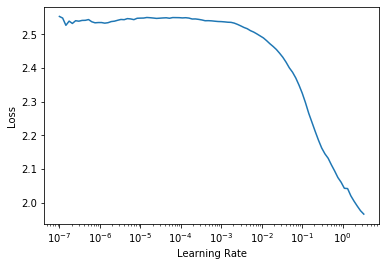

In [126]:
learn.lr_find()

In [127]:
learn.fit_flat_cos(10, 5e-1)

epoch,train_loss,valid_loss,accuracy,time
0,1.219704,1.006934,0.503998,00:01
1,1.058438,0.986266,0.501599,00:01
2,1.009553,0.987013,0.523191,00:01
3,0.988781,0.968561,0.531387,00:01
4,0.973449,0.980897,0.530188,00:01
5,0.963466,0.958104,0.552179,00:01
6,0.958014,0.994968,0.548781,00:01
7,0.956507,0.942835,0.552579,00:01
8,0.938410,0.923032,0.572571,00:01
9,0.917081,0.909406,0.578569,00:01


In [128]:
learn.fit_flat_cos(10, 3e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.905135,0.902838,0.594762,00:01
1,0.896358,0.884210,0.609156,00:01
2,0.885417,0.867429,0.617153,00:01
3,0.862812,0.818128,0.639944,00:01
4,0.849430,0.834130,0.645142,00:01
5,0.834270,0.792426,0.661735,00:01
6,0.822814,0.820977,0.654738,00:01
7,0.813265,0.775233,0.666333,00:01
8,0.796570,0.768297,0.668932,00:01
9,0.773133,0.754853,0.677329,00:01


In [129]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.743100,0.751154,0.683527,00:01
1,0.736195,0.728985,0.698721,00:01
2,0.727216,0.716557,0.705718,00:01
3,0.718730,0.707123,0.707117,00:01
4,0.712066,0.713270,0.704318,00:01
5,0.704787,0.695831,0.711715,00:01
6,0.696806,0.692590,0.708916,00:01
7,0.690870,0.687211,0.714314,00:01
8,0.685435,0.677321,0.720712,00:01
9,0.672546,0.674107,0.722511,00:01


In [130]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.672558,0.673633,0.718713,00:01
1,0.666999,0.665975,0.718313,00:01
2,0.658013,0.673943,0.719712,00:01
3,0.654190,0.648065,0.729908,00:01
4,0.642698,0.651811,0.737305,00:01
5,0.639139,0.632406,0.738305,00:01
6,0.621927,0.629146,0.751300,00:01
7,0.615632,0.611753,0.749100,00:01
8,0.594606,0.590405,0.758497,00:01
9,0.572460,0.584543,0.762295,00:01


In [131]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.580869,0.581676,0.765694,00:01
1,0.565651,0.568023,0.768692,00:01
2,0.558679,0.618771,0.763695,00:01
3,0.539904,0.533659,0.780088,00:01
4,0.524131,0.512036,0.790284,00:01
5,0.510680,0.483582,0.800480,00:01
6,0.493857,0.492251,0.786485,00:01
7,0.477195,0.437257,0.819872,00:01
8,0.453997,0.416488,0.820272,00:01
9,0.430688,0.406522,0.823071,00:01


In [132]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.450985,0.452890,0.809476,00:01
1,0.441650,0.393416,0.825270,00:01
2,0.436622,0.412942,0.821072,00:01
3,0.423446,0.385138,0.835466,00:01
4,0.422868,0.401786,0.833667,00:01
5,0.411759,0.363909,0.841663,00:01
6,0.407517,0.402905,0.832667,00:01
7,0.408031,0.397221,0.836266,00:01
8,0.399259,0.351702,0.841863,00:01
9,0.379642,0.342559,0.845262,00:01


In [133]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.381743,0.412624,0.833467,00:01
1,0.397062,0.361644,0.845262,00:01
2,0.388242,0.382145,0.838864,00:01
3,0.390010,0.348545,0.844862,00:01
4,0.380231,0.359762,0.846461,00:01
5,0.382811,0.359448,0.846262,00:01
6,0.376837,0.364615,0.826469,00:01
7,0.367882,0.348213,0.848661,00:01
8,0.360692,0.330295,0.851859,00:01
9,0.343513,0.321908,0.851459,00:01


In [136]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.337632,0.339327,0.839664,00:01
1,0.349193,0.332622,0.844262,00:01
2,0.355521,0.456186,0.815074,00:01
3,0.370060,0.352162,0.845262,00:01
4,0.365616,0.377841,0.839264,00:01
5,0.359209,0.334448,0.841263,00:01
6,0.357295,0.418594,0.844062,00:01
7,0.346235,0.330199,0.844462,00:01
8,0.336742,0.323736,0.849860,00:01
9,0.325210,0.311011,0.849060,00:01


In [78]:
learn.save('best_97')

In [103]:
learn.load('best_97')

In [104]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.136823,0.173501,0.942023,00:01
1,0.133433,0.107160,0.972811,00:01
2,0.135595,0.120637,0.966413,00:01
3,0.130542,0.120883,0.968013,00:01
4,0.126334,0.231265,0.932027,00:01
5,0.127082,0.105551,0.974610,00:01
6,0.121557,0.137042,0.964414,00:01
7,0.121371,0.082664,0.980208,00:01
8,0.103670,0.074843,0.982207,00:01
9,0.080927,0.063728,0.985606,00:01


In [105]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.116839,0.128422,0.963215,00:01
1,0.118754,0.089781,0.980408,00:01
2,0.112206,0.101694,0.974610,00:01
3,0.109531,0.090374,0.977809,00:01
4,0.106002,0.123709,0.968213,00:01
5,0.106811,0.091484,0.979608,00:01
6,0.106752,0.095809,0.973611,00:01
7,0.109547,0.092528,0.977809,00:01
8,0.095405,0.063133,0.985806,00:01
9,0.074111,0.060948,0.987005,00:01


In [106]:
learn.fit_flat_cos(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.048256,0.058364,0.987605,00:01
1,0.045497,0.058977,0.987205,00:01
2,0.043150,0.055751,0.988605,00:01
3,0.042563,0.055751,0.989204,00:01
4,0.042398,0.054727,0.989404,00:01
5,0.042698,0.054355,0.989804,00:01
6,0.041467,0.063653,0.987205,00:01
7,0.040760,0.056509,0.988804,00:01
8,0.039952,0.057567,0.989204,00:01
9,0.039234,0.057416,0.989004,00:01


In [107]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.135121,0.154555,0.957017,00:01
1,0.125315,0.128096,0.966413,00:01
2,0.117933,0.188146,0.936026,00:01
3,0.109983,0.081640,0.980208,00:01
4,0.107026,0.127936,0.967813,00:01
5,0.105371,0.091494,0.978409,00:01
6,0.098738,0.120604,0.969012,00:01
7,0.092982,0.083852,0.978209,00:01
8,0.085211,0.067614,0.983806,00:01
9,0.065325,0.058188,0.987005,00:01


In [108]:
learn.fit_flat_cos(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.105398,0.297833,0.917233,00:01
1,0.098964,0.104932,0.976809,00:01
2,0.094816,0.186346,0.941423,00:01
3,0.098283,0.078315,0.982607,00:01
4,0.095205,0.141487,0.961415,00:01
5,0.100657,0.085405,0.979008,00:01
6,0.094476,0.106262,0.971811,00:01
7,0.092265,0.076843,0.982807,00:01
8,0.086314,0.068542,0.986605,00:01
9,0.067043,0.063351,0.986006,00:01


In [109]:
learn.fit_flat_cos(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.052976,0.080350,0.979008,00:01
1,0.055206,0.054744,0.988605,00:01
2,0.054570,0.100143,0.975010,00:01
3,0.058247,0.056136,0.988605,00:01
4,0.053903,0.066806,0.987005,00:01
5,0.055376,0.070188,0.986006,00:01
6,0.054731,0.075207,0.981807,00:01
7,0.054264,0.062656,0.988205,00:01
8,0.045611,0.069597,0.986006,00:01
9,0.039707,0.057584,0.989404,00:01


In [111]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.039487,0.053729,0.990004,00:01
1,0.041695,0.057928,0.988804,00:01
2,0.062351,0.225881,0.943423,00:01
3,0.069930,0.064796,0.986405,00:01
4,0.057938,0.068598,0.983207,00:01
5,0.048726,0.070294,0.984806,00:01
6,0.041273,0.052695,0.989404,00:01
7,0.037753,0.051803,0.990404,00:01
8,0.033338,0.050086,0.990204,00:01
9,0.031144,0.049022,0.990004,00:01


In [112]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.029843,0.049667,0.990004,00:01
1,0.051278,0.084006,0.980608,00:01
2,0.072963,0.298767,0.893842,00:01
3,0.072552,0.058935,0.986206,00:01
4,0.061636,0.061237,0.986405,00:01
5,0.053571,0.052721,0.989204,00:01
6,0.044774,0.058090,0.989204,00:01
7,0.038523,0.050177,0.990004,00:01
8,0.034479,0.050764,0.990604,00:01
9,0.032611,0.050724,0.990604,00:01


In [113]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.029036,0.051445,0.990604,00:01
1,0.044909,0.093460,0.973411,00:01
2,0.070327,0.229885,0.936226,00:01
3,0.067707,0.077791,0.981008,00:01
4,0.059655,0.078814,0.980408,00:01
5,0.054851,0.044646,0.991603,00:01
6,0.044784,0.051863,0.989804,00:01
7,0.036911,0.052026,0.990604,00:01
8,0.032634,0.047069,0.991204,00:01
9,0.029434,0.047303,0.991004,00:01


In [114]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.028076,0.058331,0.988405,00:01
1,0.051083,0.065927,0.984606,00:01
2,0.075236,0.371411,0.885846,00:01
3,0.071216,0.058957,0.985806,00:01
4,0.063516,0.058030,0.987205,00:01
5,0.055748,0.052641,0.988605,00:01
6,0.046958,0.057597,0.988605,00:01
7,0.037689,0.051109,0.990604,00:01
8,0.033815,0.049178,0.990804,00:01
9,0.029872,0.049170,0.990804,00:01


In [115]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.026340,0.053343,0.989604,00:01
1,0.038255,0.062830,0.986805,00:01
2,0.062275,0.208249,0.946621,00:01
3,0.071526,0.065842,0.984206,00:01
4,0.061046,0.063874,0.986605,00:01
5,0.050015,0.060436,0.987605,00:01
6,0.040265,0.055634,0.989804,00:01
7,0.035122,0.050930,0.990404,00:01
8,0.031769,0.050973,0.990404,00:01
9,0.029459,0.051305,0.990204,00:01


In [116]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.026864,0.052114,0.990804,00:01
1,0.043426,0.077318,0.980208,00:01
2,0.064091,0.126120,0.962215,00:01
3,0.065786,0.059280,0.989604,00:01
4,0.058649,0.112179,0.966613,00:01
5,0.047603,0.060049,0.987805,00:01
6,0.040983,0.054334,0.989804,00:01
7,0.034344,0.052483,0.989804,00:01
8,0.031353,0.051134,0.991004,00:01
9,0.028767,0.051364,0.990604,00:01
